In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
train_path = './drive/My Drive/636/dataset/part6/trainset.csv'
trainset = pd.read_csv(train_path, index_col=0)
test_path = './drive/My Drive/636/dataset/part6/testset.csv'
testset = pd.read_csv(test_path, index_col=0)

In [6]:
print(trainset.shape, testset.shape)

(127308, 158) (22325, 158)


In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[2:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X_train = create_segments(trainset, 10)
X_test = create_segments(testset, 10)

In [0]:
y_train = trainset['label'].to_numpy()
y_test = testset['label'].to_numpy()

In [0]:
idx = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx], y_train[idx]

Build model

In [12]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten, Bidirectional
from keras.callbacks import History, EarlyStopping

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Model 8


In [0]:
def create_model_8():
  model = Sequential()
  model.add(LSTM(128, activation='relu', return_sequences = True))
  model.add(Dropout(0.5))

  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(BatchNormalization())

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [81]:
model_8 = create_model_8()
history = model_8.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

ValueError: ignored

In [0]:
score = model.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

Model 6

In [0]:
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, Activation, MaxPooling1D, Dropout, Dense, LSTM, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint

In [0]:
def create_model_7():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(LSTM(50, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [65]:
model = create_model_7()
checkPoint = ModelCheckpoint(filepath='chkPt1.h5', verbose=1, save_best_only=True)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 9, 64)             20032     
_________________________________________________________________
batch_normalization_16 (Batc (None, 9, 64)             256       
_________________________________________________________________
activation_16 (Activation)   (None, 9, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 43,339
Trainable params: 43,211
Non-trainable params: 128
_______________________________________________

In [66]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Train on 108211 samples, validate on 19097 samples
Epoch 1/100
 - 27s - loss: 0.5872 - acc: 0.7001 - val_loss: 0.7322 - val_acc: 0.4968
Epoch 2/100
 - 26s - loss: 0.5348 - acc: 0.7445 - val_loss: 0.8522 - val_acc: 0.6645
Epoch 3/100
 - 26s - loss: 0.5647 - acc: 0.7147 - val_loss: 0.7791 - val_acc: 0.4840
Epoch 4/100
 - 26s - loss: 0.5230 - acc: 0.7519 - val_loss: 0.6796 - val_acc: 0.7101
Epoch 5/100
 - 25s - loss: 0.4964 - acc: 0.7722 - val_loss: 0.7228 - val_acc: 0.6162
Epoch 6/100
 - 25s - loss: 0.4809 - acc: 0.7754 - val_loss: 1.0020 - val_acc: 0.4653
Epoch 7/100
 - 26s - loss: 0.4900 - acc: 0.7733 - val_loss: 0.8730 - val_acc: 0.4725
Epoch 8/100
 - 26s - loss: 0.5024 - acc: 0.7632 - val_loss: 0.9120 - val_acc: 0.4634
Epoch 9/100
 - 25s - loss: 0.4677 - acc: 0.7837 - val_loss: 0.7978 - val_acc: 0.5055
Epoch 10/100
 - 26s - loss: 0.4556 - acc: 0.7908 - val_loss: 0.9160 - val_acc: 0.5560
Epoch 11/100
 - 26s - loss: 0.4631 - acc: 0.7860 - val_loss: 0.9049 - val_acc: 0.6298
Epoch 12/100

test loss:  1.0742935105934657 test acc:  0.6919149160385132


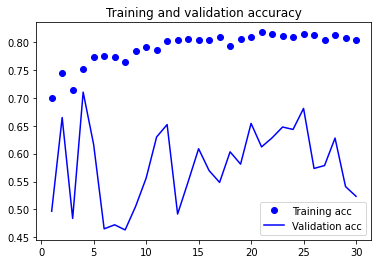

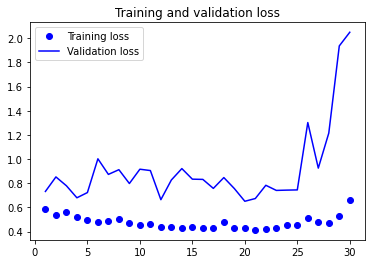

In [67]:
score = model.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])
draw(history)

In [0]:
model.save('./drive/My Drive/636/model/model7_69.csv')

Model 3

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_3():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 128, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 64))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [69]:
# create model
model_1 = create_model_3()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10, 128)           20096     
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 128)           131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 201,153
Trainable params: 201,153
Non-trainable params: 0
_______________________________________________

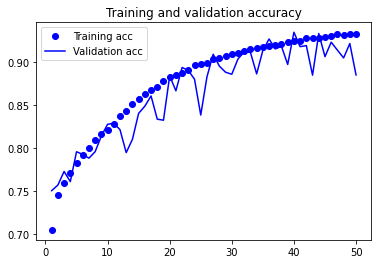

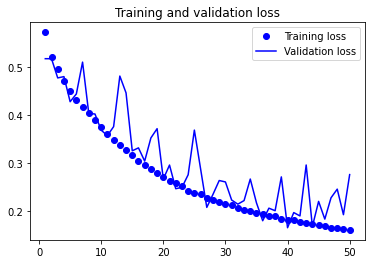

In [70]:
draw(history)

In [0]:
model_1.save('./drive/My Drive/636/model/model1_61.csv')

In [24]:
# create model
model = create_model_3()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10, 128)           20096     
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 201,153
Trainable params: 201,153
Non-trainable params: 0
________________________________________________

In [25]:
score

[1.6096314585619385, 0.5195520520210266]

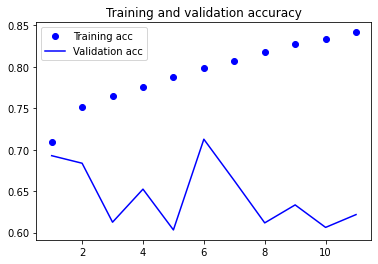

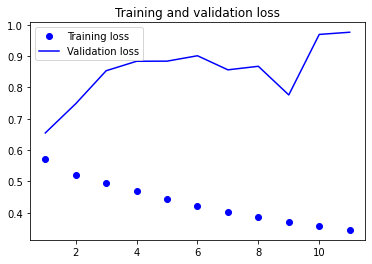

In [26]:
draw(history)

**model1**

In [0]:
def create_model_1():
  model = Sequential()
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
model = create_model_1()
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

In [0]:
model.summary()

In [0]:
score

[0.1905941534555077, 0.922271192073822]

In [0]:
draw(history)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 50
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156

In [0]:
def create_model_2():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 128, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 64))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
#                            verbose=2, mode='min')
# callbacks_list = [early_stop]

In [0]:
# create model
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

In [0]:
score

[0.27144050713633877, 0.886232316493988]

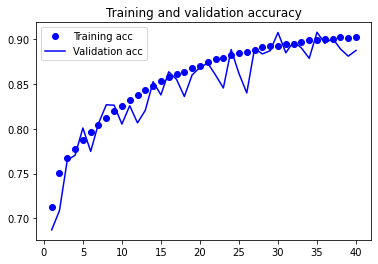

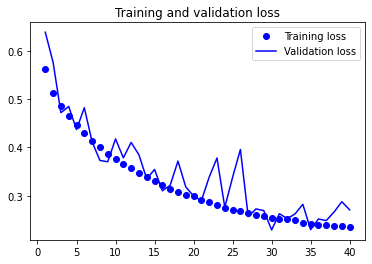

In [0]:
draw(history)

fixed dataset

In [0]:
model = create_model_1()
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Train on 101846 samples, validate on 25462 samples
Epoch 1/100
 - 44s - loss: 0.5792 - acc: 0.6982 - val_loss: 0.8587 - val_acc: 0.5859
Epoch 2/100
 - 43s - loss: 0.5278 - acc: 0.7400 - val_loss: 1.0972 - val_acc: 0.5770
Epoch 3/100
 - 42s - loss: 0.4959 - acc: 0.7606 - val_loss: 1.2309 - val_acc: 0.5430
Epoch 4/100
 - 42s - loss: 0.4669 - acc: 0.7753 - val_loss: 1.1104 - val_acc: 0.5398
Epoch 5/100
 - 42s - loss: 0.4441 - acc: 0.7884 - val_loss: 1.0366 - val_acc: 0.5596
Epoch 6/100
 - 42s - loss: 0.4285 - acc: 0.7957 - val_loss: 1.3331 - val_acc: 0.4480
Epoch 7/100
 - 42s - loss: 0.4147 - acc: 0.8033 - val_loss: 1.6238 - val_acc: 0.4618
Epoch 8/100
 - 41s - loss: 0.4018 - acc: 0.8120 - val_loss: 1.2953 - val_acc: 0.4964
Epoch 9/100
 - 41s - loss: 0.3881 - acc: 0.8197 - val_loss: 1.3635 - val_acc: 0.5014
Epoch 10/100
 - 41s - loss: 0.3762 - acc: 0.8289 - val_loss: 1.2620 - val_acc: 0.5062
Epoch 11/100
 - 41s - loss: 0.3666 - acc: 0.8338 - val_loss: 1.4781 - val_acc: 0.4522
Epoch 00011:

In [0]:
score

[1.8814200358416864, 0.5294574499130249]

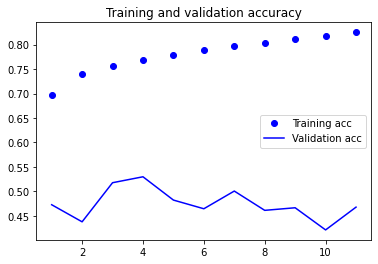

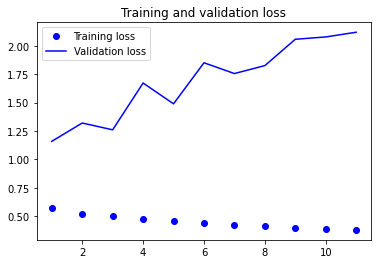

In [0]:
draw(history)

In [0]:
# create model
model = create_model_2()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2)
score = model.evaluate(X_test, y_test, verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10, 128)           20096     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 201,153
Trainable params: 201,153
Non-trainable params: 0
_________________________________________________________________
Train on 101846 samples, validate on 25462 samples
Epoch 1/100
 - 46s - loss: 0.5704 - acc: 0.7047 - val_loss: 0.6

KeyboardInterrupt: ignored

In [0]:
score

[1.0481356264442239, 0.5813214182853699]

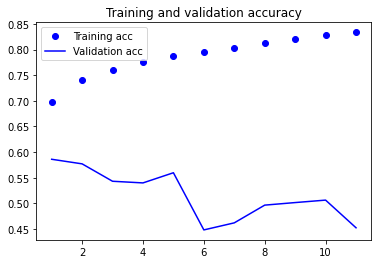

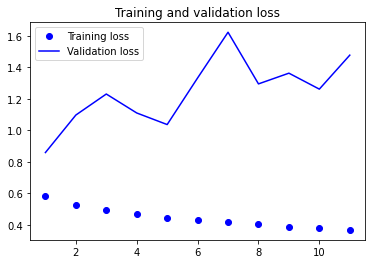

In [0]:
draw(history)